In [2]:
import os
import numpy as np
import torch
import torch.fft
import libra_py.dynamics.exact_torch.compute as compute
import matplotlib.pyplot as plt

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=24)      # fontsize of the x and y labels
plt.rc('legend', fontsize=24)     # legend fontsize
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=24)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

In [2]:
# Define Tully's simple avoided crossing diabatic potential matrix
def tully_potential_matrix(Q, params):
    """
    Q: Tensor with shape [ndof, Ngrid]
    Returns diabatic potential matrix [2, 2, Ngrid]
    """
    x = Q[0]  # Assume 1D nuclear coordinate

    A = params.get("A", 0.01)
    B = params.get("B", 1.6)
    C = params.get("C", 0.005)
    D = params.get("D", 1.0)


    # Diabatic state 1 potential
    V11 = torch.where(
    x >= 0,
    A * (1 - torch.exp(-B * x)),
    -A * (1 - torch.exp(B * x))
    )
    V22 = -V11                         # Diabatic state 2 potential (mirror)
    V12 = C * torch.exp(-D * x**2)    # Coupling between diabatic states

    shape = x.shape
    Vmat = torch.zeros((*shape, 2, 2), dtype=torch.cfloat)
    Vmat[..., 0, 0] = V11
    Vmat[..., 1, 1] = V22
    Vmat[..., 0, 1] = V12
    Vmat[..., 1, 0] = torch.conj(V12)

    return Vmat

In [3]:
# Set up parameters
params = {
    "prefix": "tully_avoided_crossing",
    "grid_size": [512],       # 1D grid
    "q_min": [-20.0],
    "q_max": [20.0],
    "save_every_n_steps": 1,
    "dt": 10.0,
    "nsteps": 200,
    "mass": [2000.0],         # realistic nuclear mass unit

    "Nstates": 2,
    "representation": "adiabatic",
    "initial_state_index": 0,   # Start in diabatic state 0
    
    "potential_fn": compute.tully_potential_matrix,
    "potential_fn_params": {
        "A": 0.01,
        "B": 1.6,
        "C": 0.005,
        "D": 1.0
    },
    "psi0_fn" : compute.gaussian_wavepacket,
    "psi0_fn_params": {
        "mass": [2000.0],
        "omega": [0.004],
        "q0": [-6.0],            # initial position left of crossing
        "p0": [20.0]             # initial momentum toward crossing
    },
    "method": "split-operator"
}



In [4]:
# Instantiate solver
solver = compute.exact_tdse_solver_multistate(params)
solver.solve()

Initializing grids
grid_size =  tensor([512])
self.ngrid =  512
Q =  torch.Size([1, 512])
dq =  tensor([0.0783])
K =  torch.Size([1, 512])
dk =  tensor([0.1568])
dV =  tensor(0.0783)
dVk =  tensor(0.1568)
T.shape =  torch.Size([512])
expT.shape =  torch.Size([512])
V.shape =  torch.Size([512, 2, 2])
expV_half.shape =  torch.Size([512, 2, 2])
Step 0: Norm = 1.0000
Step 1: Norm = 1.0000
Step 2: Norm = 1.0000
Step 3: Norm = 1.0000
Step 4: Norm = 1.0000
Step 5: Norm = 1.0000
Step 6: Norm = 1.0000
Step 7: Norm = 1.0000
Step 8: Norm = 1.0000
Step 9: Norm = 1.0000
Step 10: Norm = 1.0000
Step 11: Norm = 1.0000
Step 12: Norm = 1.0000
Step 13: Norm = 1.0000
Step 14: Norm = 1.0000
Step 15: Norm = 1.0000
Step 16: Norm = 1.0000
Step 17: Norm = 1.0000
Step 18: Norm = 1.0000
Step 19: Norm = 1.0000
Step 20: Norm = 1.0000
Step 21: Norm = 1.0000
Step 22: Norm = 1.0000
Step 23: Norm = 1.0000
Step 24: Norm = 1.0000
Step 25: Norm = 1.0000
Step 26: Norm = 1.0000
Step 27: Norm = 1.0000
Step 28: Norm = 1.0000

/home/alexvakimov/SOFTWARE/libra/_build/src/libra_py/dynamics/exact_torch/compute.py:484: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1724640795723/work/aten/src/ATen/native/Copy.cpp:305.)
  self.total_energy[istep] = KE + PE


/tmp/ipykernel_282216/4249182734.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  f = torch.load("tully_avoided_crossing.pt")
/tmp/ipykernel_282216/4249182734.py:2: UserW

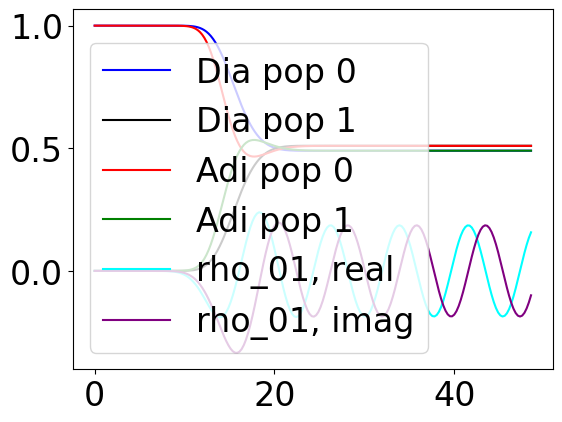

In [5]:
f = torch.load("tully_avoided_crossing.pt")
t = torch.tensor(f["time"])/41.0  # to convert to fs
rho_dia = torch.tensor(f["rho_dia_all"])
rho_adi = torch.tensor(f["rho_adi_all"])

plt.plot(t[:], rho_dia[:,0,0], label="Dia pop 0", color="blue")
plt.plot(t[:], rho_dia[:,1,1], label="Dia pop 1", color="black")

plt.plot(t[:], rho_adi[:,0,0], label="Adi pop 0", color="red")
plt.plot(t[:], rho_adi[:,1,1], label="Adi pop 1", color="green")

plt.plot(t[:], rho_adi[:,0,1].real, label="rho_01, real", color="cyan")
plt.plot(t[:], rho_adi[:,0,1].imag, label="rho_01, imag", color="purple")

plt.legend()
plt.show()

In [17]:
def plot_snapshots(prefix, outfile="density.png"):
    """
    Plot initial and final adiabatic densities from trajectory data.

    Parameters
    ----------
    prefix : str
        Path to directory containing data.pt
    outfile : str, optional
        Filename for saving the plot (saved inside `prefix` by default)
    """
    # Load data
    f = torch.load(os.path.join(prefix, "data.pt"))
    print(f.keys())

    # Coordinate grid
    x = np.linspace(f["q_min"][0], f["q_max"][0], f["grid_size"][0])
    nsteps = f["nsteps"]
    print("nsteps =", nsteps)
    print("psi_r_adi_all shape:", f["psi_r_adi_all"].shape)

    # Initial and final densities
    psi = f["psi_r_adi_all"]  # shape: [nsteps, Ngrid, nstates]
    rho0_init = torch.abs(psi[0, :, 0])**2
    rho1_init = torch.abs(psi[0, :, 1])**2
    rho0_finl = torch.abs(psi[-1, :, 0])**2
    rho1_finl = torch.abs(psi[-1, :, 1])**2

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(x, rho0_init, color="red", label=r"$\psi_0(0)$")
    plt.plot(x, rho1_init, color="blue", label=r"$\psi_1(0)$")
    plt.plot(x, rho0_finl, "--", color="red", label=r"$\psi_0(T)$")
    plt.plot(x, rho1_finl, "--", color="blue", label=r"$\psi_1(T)$")

    plt.xlabel("x")
    plt.ylabel(r"$|\psi(x)|^2$")
    plt.legend()
    plt.tight_layout()

    outpath = os.path.join(prefix, outfile)
    plt.savefig(outpath, dpi=200)
    plt.close()
    print(f"Saved plot to {outpath}")

    
plot_snapshots("EXACT-model_Tully1-istate_0-q0_-10.0-p0_20.0")

/tmp/ipykernel_225149/2033625135.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  f = torch.load(os.path.join(prefix, "data.pt"))


dict_keys(['grid_size', 'ndim', 'q_min', 'q_max', 'save_every_n_steps', 'dt', 'nsteps', 'nsnaps', 'mass', 'psi_r_adi', 'psi_r_dia', 'psi_k_adi', 'psi_k_dia', 'rho_dia_all', 'rho_adi_all', 'psi_r_dia_all', 'psi_r_adi_all', 'psi_k_dia_all', 'psi_k_adi_all', 'E', 'U', 'time', 'Q', 'K', 'dq', 'dk', 'dV', 'dVk', 'kinetic_energy', 'potential_energy', 'total_energy', 'population_right', 'norm', 'V', 'T'])
nsteps = 200
psi_r_adi_all shape: torch.Size([200, 512, 2])
Saved plot to EXACT-model_Tully1-istate_0-q0_-10.0-p0_20.0/density.png


In [2]:
import commons

In [3]:
pref = "EXACT-model_Tully1-istate_0-q0_-10.0-p0_20.0"
commons.plot_snapshots(pref)
commons.plot_populations(pref)

/home/alexvakimov/Projects/Project_Methods_Goodness/commons.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  f = torch.load(os.path.join(prefix, "data.pt"))


dict_keys(['grid_size', 'ndim', 'q_min', 'q_max', 'save_every_n_steps', 'dt', 'nsteps', 'nsnaps', 'mass', 'psi_r_adi', 'psi_r_dia', 'psi_k_adi', 'psi_k_dia', 'rho_dia_all', 'rho_adi_all', 'psi_r_dia_all', 'psi_r_adi_all', 'psi_k_dia_all', 'psi_k_adi_all', 'E', 'U', 'time', 'Q', 'K', 'dq', 'dk', 'dV', 'dVk', 'kinetic_energy', 'potential_energy', 'total_energy', 'population_right', 'norm', 'V', 'T'])
nsteps = 200
psi_r_adi_all shape: torch.Size([200, 512, 2])
Saved plot to EXACT-model_Tully1-istate_0-q0_-10.0-p0_20.0/density.png


/home/alexvakimov/Projects/Project_Methods_Goodness/commons.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  f = torch.load(os.path.join(prefix, "data.pt"))
/home/alexva

Saved plot to EXACT-model_Tully1-istate_0-q0_-10.0-p0_20.0/populations.png


In [1]:
import libra_py.models.Tully_for_exact_pytorch as Tully

torch.Size([1, 100])
torch.Size([100, 2, 2])


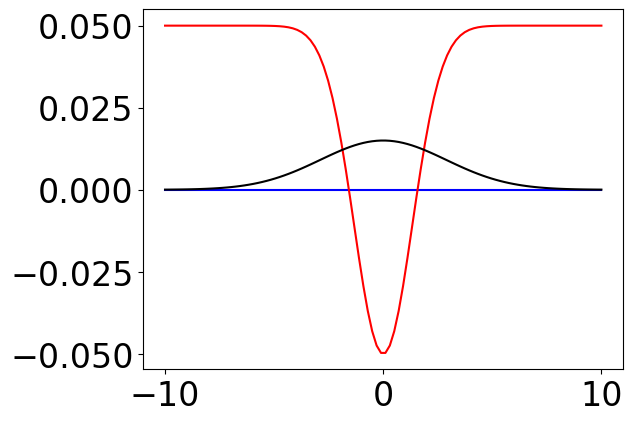

In [8]:
x = np.linspace(-10.0, 10.0, 100)
q = torch.tensor(x)
q = q.reshape(1, -1)
print(q.shape)
V = Tully.tully_model2_dual_avoided_crossing(q, {})
print(V.shape)

plt.plot(x, V[:, 0, 0], color="blue")
plt.plot(x, V[:, 1, 1], color="red")
plt.plot(x, V[:, 0, 1], color="black")

In [13]:
def plot_PES(prefix, outfile="PES.png"):
    """
    Plot diabatic and adiabatic surfaces.

    Parameters
    ----------
    prefix : str
        Path to directory containing data.pt
    outfile : str, optional
        Filename for saving the plot (saved inside `prefix` by default)
    """
    # Load data
    f = torch.load(os.path.join(prefix, "data.pt"))
    print(f.keys())

    # Coordinate grid
    x = np.linspace(f["q_min"][0], f["q_max"][0], f["grid_size"][0])
    nsteps = f["nsteps"]
    print("nsteps =", nsteps)
    print("psi_r_adi_all shape:", f["psi_r_adi_all"].shape)

    # Initial and final densities
    V = f["V"]  # shape: [Ngrid, nstates, nstates]
    E = f["E"]  # shape: [Ngrid, nstates]
    print(V.shape)
    print(E.shape)
    
    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(x, V[:, 0, 0], color="red", label=r"$V_{00}$")
    plt.plot(x, V[:, 1, 1], color="blue", label=r"$V_{11}$")
    plt.plot(x, V[:, 0, 1], color="black", label=r"$V_{01}$")
    plt.plot(x, E[:, 0], ls="--", color="red", label=r"$E_0$")
    plt.plot(x, E[:, 1], ls="--", color="blue", label=r"$E_1$")

    plt.xlabel("x, a.u.")
    plt.ylabel(r"Energy, a.u.")
    plt.legend()
    plt.tight_layout()

    outpath = os.path.join(prefix, outfile)
    #plt.show()
    plt.savefig(outpath, dpi=300)
    plt.close()
    print(f"Saved plot to {outpath}")
    
    
plot_PES("EXACT-model_Tully1-istate_0-q0_-10.0-p0_20.0")

/tmp/ipykernel_249988/3875659978.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  f = torch.load(os.path.join(prefix, "data.pt"))


dict_keys(['grid_size', 'ndim', 'q_min', 'q_max', 'save_every_n_steps', 'dt', 'nsteps', 'nsnaps', 'mass', 'psi_r_adi', 'psi_r_dia', 'psi_k_adi', 'psi_k_dia', 'rho_dia_all', 'rho_adi_all', 'psi_r_dia_all', 'psi_r_adi_all', 'psi_k_dia_all', 'psi_k_adi_all', 'E', 'U', 'time', 'Q', 'K', 'dq', 'dk', 'dV', 'dVk', 'kinetic_energy', 'potential_energy', 'total_energy', 'population_right', 'norm', 'V', 'T'])
nsteps = 200
psi_r_adi_all shape: torch.Size([200, 512, 2])
torch.Size([512, 2, 2])
torch.Size([512, 2])
Saved plot to EXACT-model_Tully1-istate_0-q0_-10.0-p0_20.0/PES.png
